# BGG Recommendation model
This notebook explores a ready model for BGG recommendations

In [1]:
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot
import glob
import numpy as np

## Sample data
The original data included a comment from the user, the game_id column was called "ID", and it had an "Unnamed: 0" column as an index. The applies changes to make the data more useable, and the sample data presented is more similar to the shuffled data

In [58]:
sample_train = pd.DataFrame([
    ('1000salmons',157354,8.0),
    ('1000salmons',128882,7.5),
    ('1000salmons',2407,4.5),
    ('1000salmons',178900,8.0),
    ('1000salmons',1294,5.0),
    ('1000salmons',12194,7.0),
    ('1000salmons',146735,7.0),
    ('1000salmons',70919,7.5),
    ('1000salmons',1406,5.0),
    ('1000salmons',1293,6.0),
    ('1000salmons',67877,6.5),
    ('1000salmons',84876,9.0),
    ('1000salmons',36218,8.5),
    ('1000salmons',19796,6.0),
    ('1000salmons',2381,6.0),
    ('1000salmons',50381,6.5),
], 
columns=['user', 'game_id', 'rating'],
index=(506155,1048906,4433087,5143551,5295373,6563448,
        6765807,6879196,8291897,8629273,10142237,10523140,
        12212202,12365209,13306961,13362454)
)

sample_test = pd.DataFrame([
    ('1000salmons',150376,7.5),
    ('1000salmons',68448,8.5),
    ('1000salmons',320,6.5),
    ('1000salmons',129622,7.5),
], 
columns=['user', 'game_id', 'rating'],
index=(13533141,14859079,14913452,15349127)
)

In [3]:
game_details_df = pd.read_csv('data/games_detailed_info.csv')
game_details_df.set_index('id')


Lets see the games our test user likes

In [59]:
sample_train.join(game_details_df[['primary']], on=sample_train.game_id)

,user,game_id,rating,primary
506155,1000salmons,157354,8.0,Five Tribes
1048906,1000salmons,128882,7.5,The Resistance: Avalon
4433087,1000salmons,2407,4.5,Sorry!
5143551,1000salmons,178900,8.0,Codenames
5295373,1000salmons,1294,5.0,Clue
6563448,1000salmons,12194,7.0,Munchkin Bites!
6765807,1000salmons,146735,7.0,Munchkin Adventure Time
6879196,1000salmons,70919,7.5,Takenoko
8291897,1000salmons,1406,5.0,Monopoly
8629273,1000salmons,1293,6.0,Boggle


We are ready to start playing. First of all, lets load the rating pipline

# Fitting the user
Unlike other models in machine learning, recommendation systems have to do some fitting on the traning data past the model creation. This fitting method is designed to handle new user data, and does not affect the model. That's why we use transform on the data, instead of predict.
We'll do some data exploration later

In [60]:
from prepare_comments import get_pipeline
pipeline = get_pipeline('models/encoded_games_detailed_info.fethear')

train_y = sample_train['rating']
test_y = sample_test['rating']

train_X = pipeline.fit_transform(sample_train.drop('rating', axis=1), train_y)
test_X = pipeline.transform(sample_test.drop('rating', axis=1))

train_X = pd.DataFrame(train_X, columns=pipeline.steps[-1][1].get_feature_names())
test_X = pd.DataFrame(test_X, columns=pipeline.steps[-1][1].get_feature_names())

Loading game data


The first game the user reviwed was "Five Tribes". Here are the game details from the original table

In [61]:
game_details_df[game_details_df['primary'] == 'Five Tribes'][
    ['yearpublished', 'minplayers', 'maxplayers', 'boardgamecategory', 'boardgamemechanic', 'averageweight']
].iloc[0]

yearpublished                                                     2014
minplayers                                                           2
maxplayers                                                           4
boardgamecategory       ['Animals', 'Arabian', 'Fantasy', 'Mythology']
boardgamemechanic    ['Auction/Bidding', 'End Game Bonuses', 'Hidde...
averageweight                                                   2.8516
Name: 157354, dtype: object

In [7]:
# TODO sum and mean reviews

In [62]:
train_X[
    ['game__weight__less_than_0.50', 'game__weight__2.01-2.5', 'game__weight__2.51-3.0', 'game__players__couples', 'game__players__multiplayers', 'game__players__party', 'game__category__card_game', 'game__category__fantasy', 'game__desc_nlp__five', 'game__desc_nlp__win', 'game__desc_nlp__dice']
].iloc[0]


game__weight__less_than_0.50    0.000000
game__weight__2.01-2.5          0.000000
game__weight__2.51-3.0          1.000000
game__players__couples          1.000000
game__players__multiplayers     1.000000
game__players__party            0.000000
game__category__card_game       0.000000
game__category__fantasy         1.000000
game__desc_nlp__five            0.458203
game__desc_nlp__win             0.105453
game__desc_nlp__dice            0.000000
Name: 0, dtype: float64

In [63]:
train_X[
    ['sum__weight__less_than_0.50', 'sum__weight__2.01-2.5', 'sum__weight__2.51-3.0', 'sum__players__couples', 'sum__players__multiplayers', 'sum__players__party', 'sum__category__card_game', 'sum__category__fantasy', 'sum__desc_nlp__five', 'sum__desc_nlp__win', 'sum__desc_nlp__dice']
].iloc[0]

sum__weight__less_than_0.50     0.000000
sum__weight__2.01-2.5           1.000000
sum__weight__2.51-3.0           2.000000
sum__players__couples          15.000000
sum__players__multiplayers     16.000000
sum__players__party            11.000000
sum__category__card_game        6.000000
sum__category__fantasy          3.000000
sum__desc_nlp__five             1.003577
sum__desc_nlp__win              0.892038
sum__desc_nlp__dice             0.437331
Name: 0, dtype: float64

In [64]:
train_X[
    ['mean__weight__less_than_0.50', 'mean__weight__2.01-2.5', 'mean__weight__2.51-3.0', 'mean__players__couples', 'mean__players__multiplayers', 'mean__players__party', 'mean__category__card_game', 'mean__category__fantasy', 'mean__desc_nlp__five', 'mean__desc_nlp__win', 'mean__desc_nlp__dice']
].iloc[0]

mean__weight__less_than_0.50   -1.000000
mean__weight__2.01-2.5          8.500000
mean__weight__2.51-3.0          8.500000
mean__players__couples          6.800000
mean__players__multiplayers     6.750000
mean__players__party            6.409091
mean__category__card_game       7.416667
mean__category__fantasy         7.500000
mean__desc_nlp__five            1.389940
mean__desc_nlp__win             1.064370
mean__desc_nlp__dice            1.043670
Name: 0, dtype: float64

## The model
Before stating, lets have a look at the model performance history (measured against validation group, in a 40 minuetes learning process), and the key metrics of the model

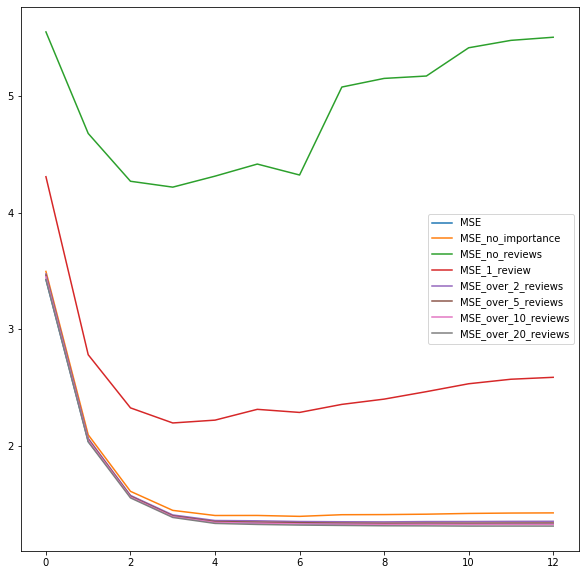

In [65]:
history = pd.read_csv('models/loss_history.csv')
axes = []
history[['MSE', 'MSE_no_importance', 'MSE_no_reviews', 'MSE_1_review', 
        'MSE_over_2_reviews', 'MSE_over_5_reviews', 'MSE_over_10_reviews', 'MSE_over_20_reviews', ]].plot( figsize=(10,10) )


In [31]:
history.iloc[-1]

Unnamed: 0             12.000000
iter                   12.000000
filenum                12.000000
batch                   0.000000
MSE                     1.329471
MSE_no_importance       1.426185
MSE_no_reviews          5.503098
MSE_1_review            2.588251
MSE_over_2_reviews      1.354251
MSE_over_5_reviews      1.340104
MSE_over_10_reviews     1.326976
MSE_over_20_reviews     1.313063
Name: 12, dtype: float64

In [12]:
model = xgb.Booster()
model.load_model('models/model_data.json')

In [13]:
f_score = model.get_fscore()
f_score = dict([ (train_X.columns[ int(key.replace('f', '')) ], int(value)) for key, value in f_score.items() ])
f_score = pd.Series(f_score).sort_values(ascending=False)

In [14]:
df_f_score = f_score.to_frame().reset_index()
df_f_score = df_f_score.rename({0: 'power'}, axis=1)

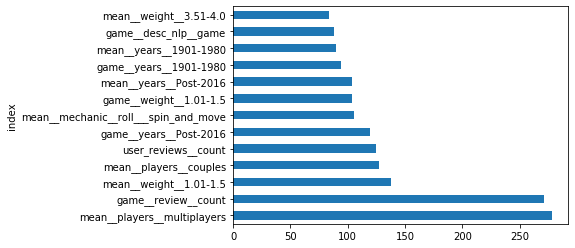

In [15]:
df_f_score.groupby('index').sum()['power'].sort_values(ascending=False).head(13).plot.barh()

## Predictions
Lets see how well our model works for this user

In [66]:
sample_predictions = pd.Series(model.predict(xgb.DMatrix(test_X)), index=sample_test.index, name='prediction')
sample_test.join(sample_predictions).join(game_details_df[['primary']], on=sample_test.game_id)


,user,game_id,rating,prediction,primary
13533141,1000salmons,150376,7.5,7.027982,Dead of Winter: A Crossroads Game
14859079,1000salmons,68448,8.5,7.003830,7 Wonders
14913452,1000salmons,320,6.5,6.207771,Scrabble
15349127,1000salmons,129622,7.5,7.062842,Love Letter


Now, lets find the best game for this user, from those he never played!

In [67]:
games_played = sample_train['game_id'].append(sample_test['game_id'])
other_games_X_base = pd.DataFrame([('1000salmons', id) 
    for id in game_details_df[ ~game_details_df.index.isin(games_played) ].index],
columns=['user', 'game_id'])

other_games_X = pipeline.transform(other_games_X_base)
other_games_X = pd.DataFrame(other_games_X, columns=pipeline.steps[-1][1].get_feature_names())


In [68]:
res = model.predict(xgb.DMatrix(other_games_X))
other_games_X_base['predicted'] = pd.Series(res)

In [69]:
other_games_X_base.join(game_details_df[['primary']], on=other_games_X_base.game_id).sort_values('predicted', ascending=False).head(10)


,user,game_id,predicted,primary
24,1000salmons,161936,8.479445,Pandemic Legacy: Season 1
17203,1000salmons,99044,8.217216,The Battle of Lepanto
2380,1000salmons,156496,8.103436,March of the Ants
17916,1000salmons,96157,8.099140,No Retreat 2: The Africa Front 1940-1942
16247,1000salmons,39426,8.046968,"Kursk, South Flank: A Panzer Grenadier Game"
82,1000salmons,146508,8.038677,T.I.M.E Stories
15343,1000salmons,96626,8.007484,Assault on Icecrown Citadel
4305,1000salmons,138166,7.985587,Huida de Silver City
7997,1000salmons,154857,7.968108,Emergence Event
1191,1000salmons,156091,7.950704,Sons of Anarchy: Men of Mayhem


### What would an empty user look like?
Just for kicks, even if this system does not work well with these users, let's see what's the recommended games for a user with no reviews

In [73]:
all_games_X_base = pd.DataFrame([(' Never Seen User ', id) 
    for id in game_details_df.index],
columns=['user', 'game_id'])

all_games_X = pipeline.transform(other_games_X_base)
all_games_X = pd.DataFrame(other_games_X, columns=pipeline.steps[-1][1].get_feature_names())


In [74]:
res = model.predict(xgb.DMatrix(all_games_X))
all_games_X_base['predicted'] = pd.Series(res)

In [75]:
all_games_X_base.join(game_details_df[['primary']], on=all_games_X_base.game_id).sort_values('predicted', ascending=False).head(10)

,user,game_id,predicted,primary
712,Never Seen User,2346,9.012450,DVONN
821,Never Seen User,119506,8.896710,Freedom: The Underground Railroad
3170,Never Seen User,91034,8.884668,Laser Chess
4396,Never Seen User,182619,8.758982,M.U.L.E. The Board Game
2543,Never Seen User,4370,8.686251,Fische Fluppen Frikadellen
6022,Never Seen User,55492,8.682696,MegaCorps
3626,Never Seen User,137238,8.658820,Time 'n' Space
775,Never Seen User,52461,8.648114,Legacy: The Testament of Duke de Crecy
18277,Never Seen User,27857,8.617093,Blindside
633,Never Seen User,8989,8.525718,Hansa


In [ ]:
df_games.loc[23]